In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules
#from custom_classes_defs.setup import *  
from custom_classes_defs.preprocessing import *
#from custom_classes_defs.Unet_like import * 
from custom_classes_defs.unet import *   
# from custom_classes_defs.fnet import * 
# from custom_classes_defs.fnet1 import *
# from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247

BATCH_SIZE = 256
# size 512 to have around 351 iterations
# size 256 to have around 707 iterations

keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

NEW_SESSION = False

# import keras_tuner as kt
# -------------------------------------------------------

2024-05-09 20:12:25.411434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 20:12:25.411873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 20:12:25.498922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 20:12:25.664834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

#if NUM_GPU:
#    # print GPU info
#    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


In [6]:
# Input data path
seis_path = './data_thebe/seis/'
label_path = './data_thebe/fault/'


In [7]:
time_start= time.time()
thebe_data = Thebe(seis_path,label_path, batch_size=BATCH_SIZE)

train_dataset = thebe_data.data_generator(sub_group='train',as_numpy=True, cache=True)
val_dataset = thebe_data.data_generator(sub_group='val',as_numpy=True, cache= True)
test_dataset = thebe_data.data_generator(sub_group='test',as_numpy=True, cache= True)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

Loading time used 2.4619369983673094 mins


In [8]:
#print(f"training data (size = {(train_dataset.cardinality().numpy())*BATCH_SIZE})")
#print(f"validation data (size = {(val_dataset.cardinality().numpy())*BATCH_SIZE})")
#print(f"test data (size = {(test_dataset.cardinality().numpy())*BATCH_SIZE})")
#print("Data images tensor:",train_dataset.element_spec[0])
#print("Data labels tensor:",train_dataset.element_spec[1])

In [9]:


# Model configurations
conf = model_config(
    epochs= 30,
    batch_size=BATCH_SIZE,
    verbose=0,
    scaling=1,
    save_path='./output/unet',
    img_shape= (96,96),
    target_size= (96,96),
    channels_dim=(1,1),
    pos_label= thebe_data.pos_label,
    new_training_session=True,
    mixed_precision = False,
    multiple_gpu_device=None
)


callbacks=conf.callbacks(chkpt_monitor='val_loss', es_patience=30, lr_patience= 10)
conf.set( validation_data=val_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.Adam(1e-3), 
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

2024-05-09 20:15:54.150299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: <class 'keras.src.optimizers.adam.Adam'>
                          loss: binary_crossentropy
                       metrics: accuracy
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: False
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: None
new_training_session: True
           pos_label: 1
           save_path: ./output/unet
             scaling: 1
         target_size: (96, 96)
           test_size: None
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 30
                    batch_size: 256
                       shuffle: False
                       verbose: 0
 

### Build model

In [10]:
### SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING
## François Chollet. Deep Learning with Python, Second Edition (Kindle Location 12675). Manning Publications Co.. 
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

#model.summary()
#plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 3,083,969
Total trainable wieghts: 3,080,193
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-09 20:16:23.755868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-09 20:16:24.904843: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-09 20:16:42.286678: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2faedaa9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 20:16:42.286740: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-05-09 20:16:42.408748: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715278603.212166 3947984 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


training elapsed time: ___31.92___ minutes
...training completed!


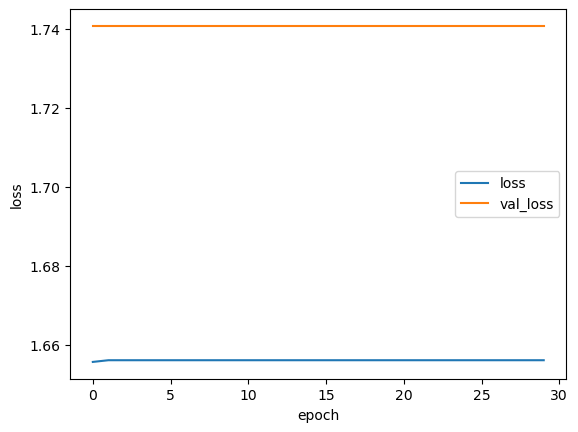

Loading time used 31.94223141670227 mins


In [11]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

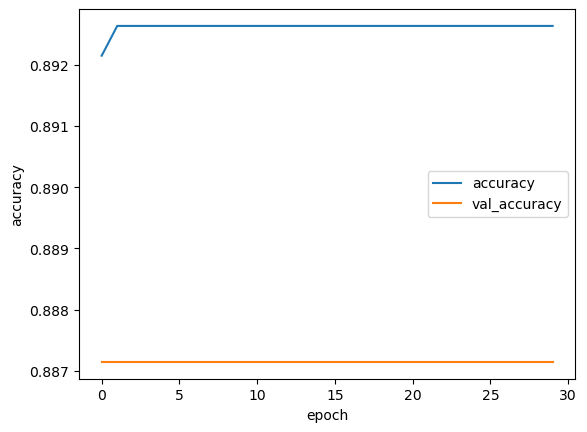

In [12]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

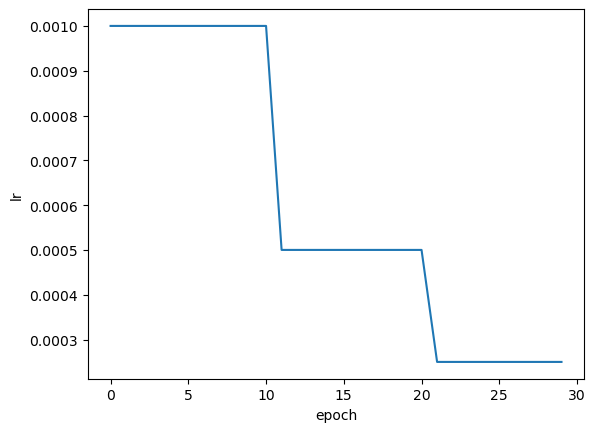

In [13]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

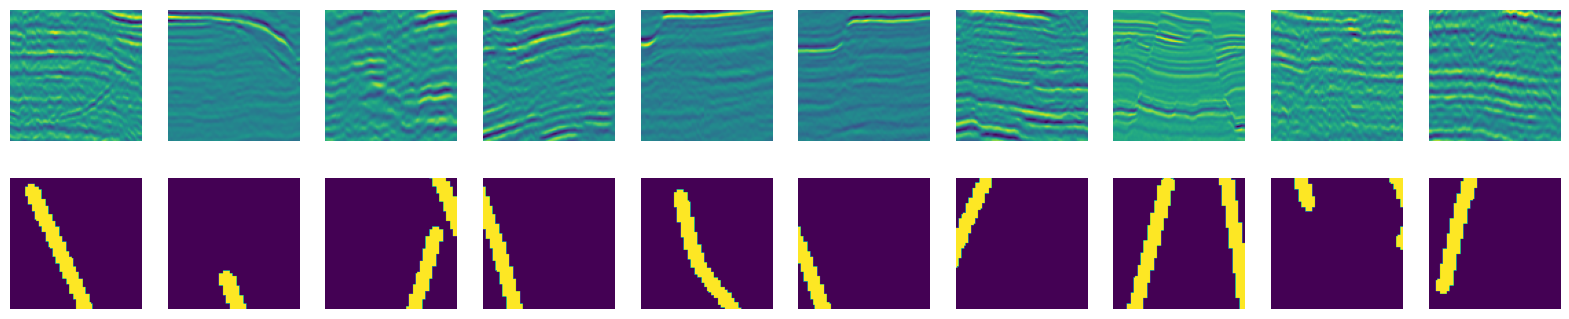

In [14]:
# check the pairs of ori images and labels

display_sample_images(train_dataset[0], train_dataset[1],(96,96))

In [15]:
time_start= time.time()
y_preds = model.predict(test_dataset[0])

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

   1/2065 [..............................] - ETA: 38:01

  11/2065 [..............................] - ETA: 11s  

  21/2065 [..............................] - ETA: 11s

  31/2065 [..............................] - ETA: 10s

  41/2065 [..............................] - ETA: 10s

  51/2065 [..............................] - ETA: 10s

  61/2065 [..............................] - ETA: 10s

  71/2065 [>.............................] - ETA: 10s

  82/2065 [>.............................] - ETA: 10s

  92/2065 [>.............................] - ETA: 10s

 102/2065 [>.............................] - ETA: 10s

 112/2065 [>.............................] - ETA: 10s

 121/2065 [>.............................] - ETA: 10s

 132/2065 [>.............................] - ETA: 10s

 141/2065 [=>............................] - ETA: 10s

 150/2065 [=>............................] - ETA: 10s

 161/2065 [=>............................] - ETA: 9s 

 171/2065 [=>............................] - ETA: 9s

 182/2065 [=>............................] - ETA: 9s

 192/2065 [=>............................] - ETA: 9s

 203/2065 [=>............................] - ETA: 9s

 213/2065 [==>...........................] - ETA: 9s

 224/2065 [==>...........................] - ETA: 9s

 234/2065 [==>...........................] - ETA: 9s

 244/2065 [==>...........................] - ETA: 9s

 254/2065 [==>...........................] - ETA: 9s

 266/2065 [==>...........................] - ETA: 9s

 277/2065 [===>..........................] - ETA: 9s

 288/2065 [===>..........................] - ETA: 9s

 299/2065 [===>..........................] - ETA: 9s

 310/2065 [===>..........................] - ETA: 8s

 320/2065 [===>..........................] - ETA: 8s

 331/2065 [===>..........................] - ETA: 8s

 342/2065 [===>..........................] - ETA: 8s

 351/2065 [====>.........................] - ETA: 8s

 361/2065 [====>.........................] - ETA: 8s

 371/2065 [====>.........................] - ETA: 8s

 380/2065 [====>.........................] - ETA: 8s

 391/2065 [====>.........................] - ETA: 8s

 401/2065 [====>.........................] - ETA: 8s

 411/2065 [====>.........................] - ETA: 8s

 421/2065 [=====>........................] - ETA: 8s

 432/2065 [=====>........................] - ETA: 8s

 443/2065 [=====>........................] - ETA: 8s

 454/2065 [=====>........................] - ETA: 8s

 465/2065 [=====>........................] - ETA: 8s

 476/2065 [=====>........................] - ETA: 8s

 486/2065 [======>.......................] - ETA: 8s

 497/2065 [======>.......................] - ETA: 7s

 508/2065 [======>.......................] - ETA: 7s

 519/2065 [======>.......................] - ETA: 7s

 529/2065 [======>.......................] - ETA: 7s

 540/2065 [======>.......................] - ETA: 7s

 552/2065 [=======>......................] - ETA: 7s

 563/2065 [=======>......................] - ETA: 7s

 573/2065 [=======>......................] - ETA: 7s

 583/2065 [=======>......................] - ETA: 7s

 593/2065 [=======>......................] - ETA: 7s

 603/2065 [=======>......................] - ETA: 7s

 612/2065 [=======>......................] - ETA: 7s

 623/2065 [========>.....................] - ETA: 7s

 634/2065 [========>.....................] - ETA: 7s

 645/2065 [========>.....................] - ETA: 7s

 656/2065 [========>.....................] - ETA: 7s

 667/2065 [========>.....................] - ETA: 7s

 678/2065 [========>.....................] - ETA: 6s

 689/2065 [=========>....................] - ETA: 6s

 700/2065 [=========>....................] - ETA: 6s

 711/2065 [=========>....................] - ETA: 6s

 721/2065 [=========>....................] - ETA: 6s

 732/2065 [=========>....................] - ETA: 6s

 743/2065 [=========>....................] - ETA: 6s

 753/2065 [=========>....................] - ETA: 6s

 763/2065 [==========>...................] - ETA: 6s

 774/2065 [==========>...................] - ETA: 6s

 785/2065 [==========>...................] - ETA: 6s

 795/2065 [==========>...................] - ETA: 6s

 806/2065 [==========>...................] - ETA: 6s

 816/2065 [==========>...................] - ETA: 6s

 827/2065 [===========>..................] - ETA: 6s

 838/2065 [===========>..................] - ETA: 6s

 849/2065 [===========>..................] - ETA: 6s

 860/2065 [===========>..................] - ETA: 6s

 870/2065 [===========>..................] - ETA: 5s

 880/2065 [===========>..................] - ETA: 5s

 891/2065 [===========>..................] - ETA: 5s

 902/2065 [============>.................] - ETA: 5s

 911/2065 [============>.................] - ETA: 5s

 922/2065 [============>.................] - ETA: 5s

 933/2065 [============>.................] - ETA: 5s

 944/2065 [============>.................] - ETA: 5s

 954/2065 [============>.................] - ETA: 5s

 964/2065 [=============>................] - ETA: 5s

 975/2065 [=============>................] - ETA: 5s

 985/2065 [=============>................] - ETA: 5s

 995/2065 [=============>................] - ETA: 5s

1005/2065 [=============>................] - ETA: 5s

1016/2065 [=============>................] - ETA: 5s

1027/2065 [=============>................] - ETA: 5s

1037/2065 [==============>...............] - ETA: 5s

1046/2065 [==============>...............] - ETA: 5s

1056/2065 [==============>...............] - ETA: 5s

1066/2065 [==============>...............] - ETA: 5s

1077/2065 [==============>...............] - ETA: 4s

1088/2065 [==============>...............] - ETA: 4s

1098/2065 [==============>...............] - ETA: 4s

1109/2065 [===============>..............] - ETA: 4s

1119/2065 [===============>..............] - ETA: 4s

1129/2065 [===============>..............] - ETA: 4s

1140/2065 [===============>..............] - ETA: 4s

1151/2065 [===============>..............] - ETA: 4s

1161/2065 [===============>..............] - ETA: 4s

1172/2065 [================>.............] - ETA: 4s

1183/2065 [================>.............] - ETA: 4s

1193/2065 [================>.............] - ETA: 4s

1204/2065 [================>.............] - ETA: 4s

1214/2065 [================>.............] - ETA: 4s

1224/2065 [================>.............] - ETA: 4s

1235/2065 [================>.............] - ETA: 4s

1246/2065 [=================>............] - ETA: 4s

1256/2065 [=================>............] - ETA: 4s

1267/2065 [=================>............] - ETA: 3s

1277/2065 [=================>............] - ETA: 3s

1288/2065 [=================>............] - ETA: 3s

1298/2065 [=================>............] - ETA: 3s

1309/2065 [==================>...........] - ETA: 3s

1320/2065 [==================>...........] - ETA: 3s

1331/2065 [==================>...........] - ETA: 3s

1342/2065 [==================>...........] - ETA: 3s

1352/2065 [==================>...........] - ETA: 3s

1363/2065 [==================>...........] - ETA: 3s

1374/2065 [==================>...........] - ETA: 3s

1385/2065 [===================>..........] - ETA: 3s

1396/2065 [===================>..........] - ETA: 3s

1407/2065 [===================>..........] - ETA: 3s

1415/2065 [===================>..........] - ETA: 3s

1425/2065 [===================>..........] - ETA: 3s

1435/2065 [===================>..........] - ETA: 3s

1446/2065 [====================>.........] - ETA: 3s

1456/2065 [====================>.........] - ETA: 3s

1467/2065 [====================>.........] - ETA: 2s

1477/2065 [====================>.........] - ETA: 2s

1487/2065 [====================>.........] - ETA: 2s

1495/2065 [====================>.........] - ETA: 2s

1505/2065 [====================>.........] - ETA: 2s

1516/2065 [=====================>........] - ETA: 2s

1526/2065 [=====================>........] - ETA: 2s

1537/2065 [=====================>........] - ETA: 2s

1548/2065 [=====================>........] - ETA: 2s

1557/2065 [=====================>........] - ETA: 2s

1568/2065 [=====================>........] - ETA: 2s

1578/2065 [=====================>........] - ETA: 2s

1588/2065 [======================>.......] - ETA: 2s

1598/2065 [======================>.......] - ETA: 2s

1608/2065 [======================>.......] - ETA: 2s

1618/2065 [======================>.......] - ETA: 2s

1628/2065 [======================>.......] - ETA: 2s

1638/2065 [======================>.......] - ETA: 2s

1647/2065 [======================>.......] - ETA: 2s

1658/2065 [=======================>......] - ETA: 2s

1669/2065 [=======================>......] - ETA: 1s

1681/2065 [=======================>......] - ETA: 1s

1691/2065 [=======================>......] - ETA: 1s

1701/2065 [=======================>......] - ETA: 1s

1711/2065 [=======================>......] - ETA: 1s

1722/2065 [========================>.....] - ETA: 1s

1732/2065 [========================>.....] - ETA: 1s

1742/2065 [========================>.....] - ETA: 1s

1753/2065 [========================>.....] - ETA: 1s

1762/2065 [========================>.....] - ETA: 1s

1772/2065 [========================>.....] - ETA: 1s

1783/2065 [========================>.....] - ETA: 1s

1793/2065 [=========================>....] - ETA: 1s

1804/2065 [=========================>....] - ETA: 1s

1816/2065 [=========================>....] - ETA: 1s

1826/2065 [=========================>....] - ETA: 1s

1836/2065 [=========================>....] - ETA: 1s

1847/2065 [=========================>....] - ETA: 1s

1857/2065 [=========================>....] - ETA: 1s

1867/2065 [==========================>...] - ETA: 0s

1876/2065 [==========================>...] - ETA: 0s

1886/2065 [==========================>...] - ETA: 0s

1897/2065 [==========================>...] - ETA: 0s

1907/2065 [==========================>...] - ETA: 0s

1918/2065 [==========================>...] - ETA: 0s

1927/2065 [==========================>...] - ETA: 0s

1937/2065 [===========================>..] - ETA: 0s

1949/2065 [===========================>..] - ETA: 0s

1960/2065 [===========================>..] - ETA: 0s

1971/2065 [===========================>..] - ETA: 0s

1982/2065 [===========================>..] - ETA: 0s

1992/2065 [===========================>..] - ETA: 0s

2002/2065 [============================>.] - ETA: 0s

2013/2065 [============================>.] - ETA: 0s

2023/2065 [============================>.] - ETA: 0s

2031/2065 [============================>.] - ETA: 0s

2040/2065 [============================>.] - ETA: 0s

2051/2065 [============================>.] - ETA: 0s

2062/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - ETA: 0s

2065/2065 [==============================] - 12s 5ms/step


Loading time used 0.279331906636556 mins


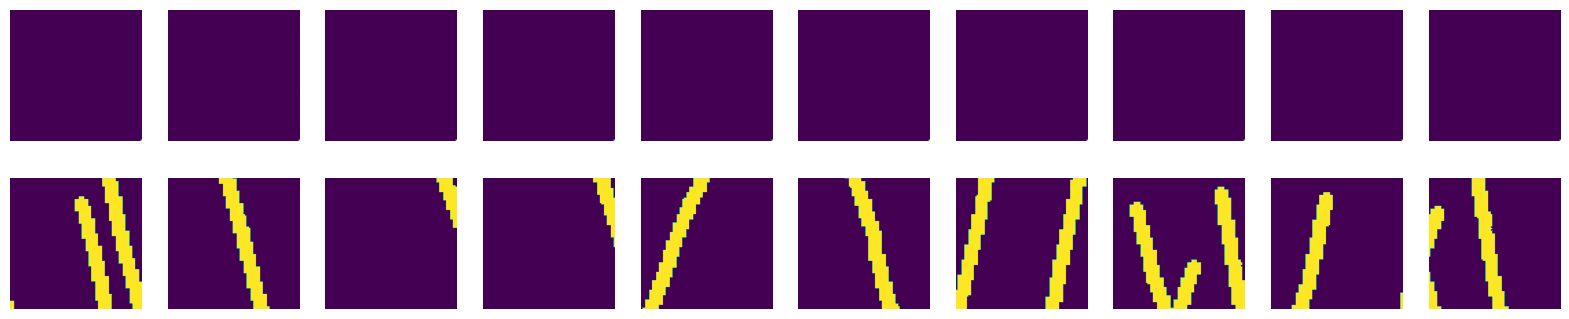

In [16]:
display_sample_images(y_preds, test_dataset[1],(96,96))

In [17]:
#time_start= time.time()

#print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))

#model.evaluate(x=test_dataset)
#time_end = (time.time()-time_start)/60
#print(f'Loading time used {time_end} mins')

In [18]:
# Using scikit-learn
#scores = m_obj.evaluate_sklearn(test_dataset, y_preds,report=True)
#print(scores)


In [19]:
#if NEW_SESSION:
#    thebe_data.display_sample_image(y_preds, 'test')